In [1]:
import gdal
import glob

In [2]:
# Create a table with the perturbations
force = pd.DataFrame({'year':np.linspace(2000,2100,11,endpoint=True)})
force['decade'] = (force.year-2000)/10.

def t_force(decade):
    return decade * 0.4

def p_higher(decade):
    return decade * 0.015

def p_lower(decade):
    return decade * -0.015

force['T'] = force.decade.map(t_force)
force['Ph'] = force.decade.map(p_higher)
force['Pl'] = force.decade.map(p_lower)

## Combinations

There are two combinations of forcings:

- higher T and lower P
- higher T and higher P

There are three years to run the experiment over:

- 2000 - no change in forcings
- 2050 - 50% change in forcings
- 2100 - 100% change in forcings

In [3]:
force = force.loc[(force.year==2000) | (force.year==2050) | (force.year==2100)]

In [4]:
np.arange(2,7,2)

array([2, 4, 6])

In [5]:
np.arange(1,6,2)

array([1, 3, 5])

In [6]:
force['combo_Ph'] = np.arange(1,6,2)
force['combo_Pl'] = np.arange(2,7,2)

In [7]:
force

,year,decade,T,Ph,Pl,combo_Ph,combo_Pl
0,2000.0,0.0,0.0,0.000,-0.000,1,2
5,2050.0,5.0,2.0,0.075,-0.075,3,4
10,2100.0,10.0,4.0,0.150,-0.150,5,6


In [8]:
force.to_pickle('./data/experiment_forcing_params.pcl')

In [18]:
# dates to produce gridded data between
strt = '1990-10-01'
nd = '2013-10-05'

# dates to use the snow scaling map
winter_strt = '10-01'
winter_nd = '05-31'

# maxweight in the raw weights data set is 15.392876
maxweight = 10.25 # maxweight of 10.25 and monthly lapse rates work best to compare with Knowles data, 7 was used to drastically reduce precip.
# 12.25 puts niwot snotel at about a scaled weight of 1.

cellsize=60
c1_weight = 0.108102336525917 # value for the c1 cell in the SWE climatology map (from QGIS)
site_elev = 3018 # met station site elevation in m

months = np.arange(1,13)
temp = [-2.1,-3.3,-5.0,-6.5,-6.2,-5.6,-5.5,-5.6,-5.2,-5.0,-4.5,-2.5] # [degC/km]
precip = [55.1,52.6,64.0,64.2,33.6,17.6,16.0,14.6,17.0,23.2,53.1,42.5] # [mm/km]

lapse = pd.DataFrame({'month':months,'T':temp,'P':precip})
lapse.index = lapse.month

lapse.P /= (1000.*1000.) # [mm/km] > [m/m]
lapse.T = lapse['T'].as_matrix()/1000. # [deg C/km] > [deg C/m]

# load the met data
c1 = pd.read_pickle('./data/c1_met_jennings_QAQC_corrP.pcl')[strt:nd]

fl = '/RHESSys/Como/auxdata/gridmet_dem_%sm_crop.tiff'%cellsize
ds = gdal.Open(fl)
dem = np.array(ds.GetRasterBand(1).ReadAsArray())

fl = '/RHESSys/Como/auxdata/gridmet_index_%sm_crop.tiff'%cellsize
ds = gdal.Open(fl)
idx = np.array(ds.GetRasterBand(1).ReadAsArray())

fl = '/RHESSys/Como/auxdata/swe_climatology_jepsen_crop.tiff'
ds = gdal.Open(fl)
weights = np.array(ds.GetRasterBand(1).ReadAsArray())/c1_weight

l,k = dem.shape
n = l*k

# reshape the rasters all in the same way
dem.shape = n
idx.shape = n
weights.shape = n

# rescale the weights so the maximum is the maximum weight
scaled = weights.copy()
scaled[scaled>1] = weights[weights>1]/(weights.max()/maxweight)
#scaled = weights/(weights.max()/maxweight)
scaled2 = scaled.copy()
scaled2.shape = (l,k)

header = '%s\n%s %s %s 1'%(n,c1.index[0].year,c1.index[0].month, c1.index[0].day)

In [19]:
def grid_data(deltaT,deltaPl,deltaPh):
    
    # load the met data
    c1 = pd.read_pickle('./data/c1_met_jennings_QAQC_corrP.pcl')[strt:nd]
    
    # alter the forcings according to delta T and delta P
    c1.Tmin += deltaT
    c1.Tmax += deltaT
    c1['Pl'] = c1.P*(1.+deltaPl)
    c1['Ph'] = c1.P*(1.+deltaPh)
    
    out = pd.DataFrame(np.ndarray((len(c1)+2,n)))
    out.iloc[0,:] = idx # add the index numbers to the data frame
    out.iloc[1,:] = dem # add the dem values to the data frame

    # make copies of the data frame for population
    Tmax = out.copy()
    Tmin = out.copy()
    Pl = out.copy()
    Ph = out.copy()

    elev_diff = dem - site_elev
    winter_strt_month = int(winter_strt.split('-')[0])
    winter_strt_day = int(winter_strt.split('-')[1])
    winter_nd_month = int(winter_nd.split('-')[0])
    winter_nd_day = int(winter_nd.split('-')[1])

    ct = 2 # start at 2 b/c the first 2 rows are full
    for day in c1.index:

        year = int(day.year)
        month = day.month

        # compute the start and end of the winter time period
        winter_strt2 = pd.datetime(year,winter_strt_month,winter_strt_day)
        winter_nd2 = pd.datetime(year,winter_nd_month,winter_nd_day)

        tlapse = lapse.loc[lapse.month==month,'T'].as_matrix()[0] # pull out the temp. lapse rate
        #plapse = lapse.loc[lapse.month==month,'P'].as_matrix()[0] # pull out the precip. lapse rate    
        plapse = 0.000015 # static precip lapse rate m/m

        Tmax.iloc[ct,:] = c1.loc[day].Tmax + (tlapse*elev_diff)
        Tmin.iloc[ct,:] = c1.loc[day].Tmin + (tlapse*elev_diff)

        if (day>winter_nd2) & (day<winter_strt2) & (c1.loc[day].P > 0): # test if the day is during the summer
            # distribute summer precip based on published lapse rates
            Pl.iloc[ct,:] = c1.loc[day].Pl + (plapse*elev_diff)
            Ph.iloc[ct,:] = c1.loc[day].Ph + (plapse*elev_diff)
            
            #if c1.loc[day].P > 0:# ensure that there is actually precipitation
        else: #f the day is during winter
            # distribute winter precip based on the Jepsen reconstruction
            Pl.iloc[ct,:] = c1.loc[day].Pl * scaled
            Ph.iloc[ct,:] = c1.loc[day].Ph * scaled
            
        ct+=1

    # convert the data frames to numpy arrays
    Tmax = Tmax.as_matrix()
    Tmin = Tmin.as_matrix()
    Pl = Pl.as_matrix()
    Ph = Ph.as_matrix()

    Pl[Pl<0] = 0. # precip that is for some reason negative should be zeroed
    Ph[Ph<0] = 0. # precip that is for some reason negative should be zeroed
    
    return Tmin,Tmax,Pl,Ph

In [20]:
# define a function that 

def gen_forcings(df):
    year = int(df['year'])
    deltaT = df['T']
    deltaPl = df['Pl']
    deltaPh = df['Ph']
    comboPh = int(df['combo_Ph'])
    comboPl = int(df['combo_Pl'])
    
    # grid out the data
    Tmin,Tmax,Pl,Ph = grid_data(deltaT,deltaPl,deltaPh)
    
    # save the data
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_combo%s.tmax'%(cellsize,comboPl),Tmax,header=header,comments='',fmt='%3.2f')
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_combo%s.tmin'%(cellsize,comboPl),Tmin,header=header,comments='',fmt='%3.2f')
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_combo%s.rain'%(cellsize,comboPl),Pl,header=header,comments='',fmt='%3.6f')
    
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_combo%s.tmax'%(cellsize,comboPh),Tmax,header=header,comments='',fmt='%3.2f')
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_combo%s.tmin'%(cellsize,comboPh),Tmin,header=header,comments='',fmt='%3.2f')
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_combo%s.rain'%(cellsize,comboPh),Ph,header=header,comments='',fmt='%3.6f')
    
    # generate the summary data
    check_Pl = pd.DataFrame({'Tmax':np.mean(Tmax[2:,:],axis=1),'Tmin':np.mean(Tmin[2:,:],axis=1),
                             'P':np.mean(Pl[2:,:],axis=1)},index = c1.index)
    
    check_Ph = pd.DataFrame({'Tmax':np.mean(Tmax[2:,:],axis=1),'Tmin':np.mean(Tmin[2:,:],axis=1),
                             'P':np.mean(Ph[2:,:],axis=1)},index = c1.index)
    
    # save the summary data
    check_Pl.to_pickle('/RHESSys/Como/clim/exp/grid%s_combo%s.pcl'%(cellsize,comboPl))
    check_Ph.to_pickle('/RHESSys/Como/clim/exp/grid%s_combo%s.pcl'%(cellsize,comboPh))
    
    return None

In [21]:
force.apply(gen_forcings,axis=1)

0     None
5     None
10    None
dtype: object

In [22]:
# get all the summary files 
files = glob.glob('/RHESSys/Como/clim/exp/grid%s*.pcl'%(cellsize))

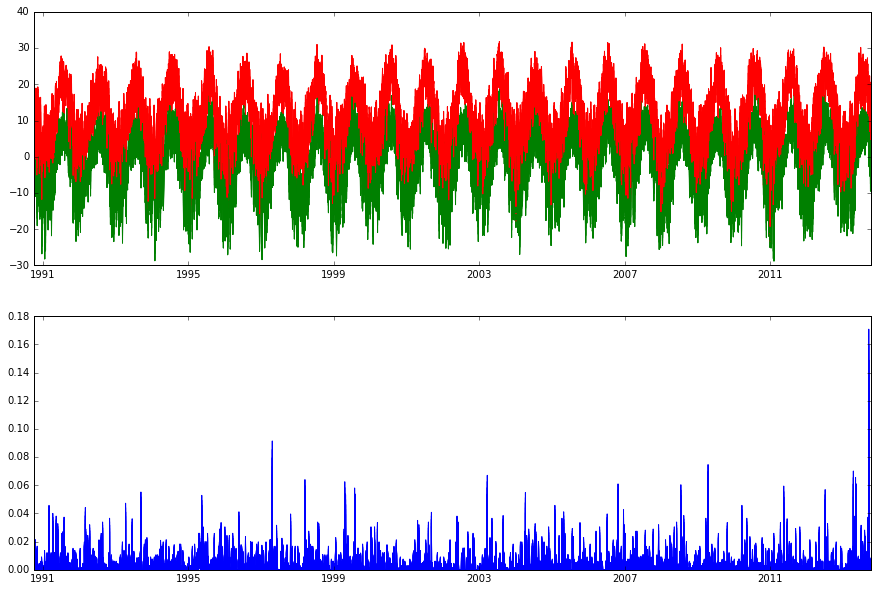

In [23]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for fl in files:
    tmp = pd.read_pickle(fl)
    ax1.plot(tmp.Tmin,'-g')
    ax1.plot(tmp.Tmax,'-r')
    
    ax2.plot(tmp.P,'-b')
